# Imports and Constants

In [23]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from datetime import datetime
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import floor
import regex as re
from collections import Counter
from utils import prompt, update_labels, master_path, get_answer_vector, hash_dataframe


label_col = 'json_booleans'


mapping = lambda s: {'background': 'context',
                     'future_work': 'context',
                    'differences': 'context',
                     'future work': 'context',
                     'motivation': 'context',
                     'similarities': 'context',
                     'extends': 'uses',
                     '*': 'context'
                     }.get(s) or s

seed = 42 #np.random.randint(0, 100)

# Load existing results

In [24]:
lazy_copy = 'uniform_base_sample_ollama_prompt_2024-07-23 21/53/00'

other_path = f'~/Desktop/2. FutureTech/uniform_sample/results/{lazy_copy.replace('/',':')}.csv'

df = pd.read_csv(other_path)

print(len(df))
df.head()

519


,Unnamed: 0.1,sentence,mcllm,modelKey,paperId,modelId_x,mc,modelId_y,mc_reduced,urop_sentence,...,modelTitle,modelId,modelYear,paperYear,pot_extends,prob_extends,modelKeyStriped,json_response,answer_vector,learned_classification
0,275,NaN,NaN,915_gans,9a1c023d80550f899a1e6ebfbc6f3579194634a8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,gans,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...",[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0...,context
1,93,private models were provided by anthropic (mod...,background,529_chinchilla,31d65e179b1d00484154b3525d93846dd82f23d8,8342b592fe238f3d230e4959b06fd10153c45db1,uses,8342b592fe238f3d230e4959b06fd10153c45db1,uses,private models were provided by anthropic (mod...,...,NaN,NaN,NaN,NaN,NaN,NaN,chinchilla,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...",[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1...,context
2,6,"considering the first goal, a language model t...",background,529_chinchilla,362cbfd0d05e139cd6cf049754098a6e1520b910,8342b592fe238f3d230e4959b06fd10153c45db1,background,8342b592fe238f3d230e4959b06fd10153c45db1,context,"considering the first goal, a language model t...",...,NaN,NaN,NaN,NaN,NaN,NaN,chinchilla,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...",[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0...,context
3,167,our work does not rely on the underlying netwo...,uses,120_mobilenet,a7a8c37d4c3d652ddb53fee6d35c064dae77a986,3647d6d0f151dc05626449ee09cc7bce55be497e,extends,3647d6d0f151dc05626449ee09cc7bce55be497e,extends,our work does not rely on the underlying netwo...,...,NaN,NaN,NaN,NaN,NaN,NaN,mobilenet,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...",[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0...,uses
4,90,to alleviate the inconsistence of the pretrain...,uses,1064_bert-large,5c712ffbebac2ac7c50fdc542b9a3fb92d06bfc9,df2b0e26d0599ce3e70df8a9da02e51594e0e992,uses,df2b0e26d0599ce3e70df8a9da02e51594e0e992,uses,to alleviate the inconsistence of the pretrain...,...,NaN,NaN,NaN,NaN,NaN,NaN,bert-large,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...",[0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0...,context


In [25]:
Counter(df['alex2'])

Counter({'background': 265,
         'uses': 111,
         'similarities': 77,
         'extends': 38,
         'differences': 13,
         'motivation': 10,
         '*': 4,
         'future work': 1})

# Parse outputs, generate confusion matrices

In [26]:
background_mask = np.array([1,1,1,1,1,   0,0,0,0,0,   0,0,0,0,0,  1,1])
uses_mask = np.array([0,0,0,0,0,   0,1,1,1,1,   1,1,0,0,0,   0,0])
extends_mask = np.array([0,0,0,0,0,   0,0,0,0,0,   0,0,1,1,0,   0,0])


def get_truth(r, verbose = False, background_mask = background_mask, uses_mask = uses_mask, extends_mask = extends_mask):
    assert(len(background_mask) == len(uses_mask) and len(uses_mask) == len(extends_mask))
    answer_vector = get_answer_vector(r, length = len(background_mask))
    
    if answer_vector is None:
        return None
    
    resolve = lambda mask: np.array([{(0,1):0, (0,0): 0, (0, -1): 1, (1,1):1, (1,0) : 0, (1, -1): 0}[(x,y)] for x,y in zip(answer_vector, mask)]).sum()
    
    background =  resolve(background_mask)
    uses = resolve(uses_mask)
    fine_tune = resolve(extends_mask)

    
    if (verbose):
        print(answer_vector)
        print(f"bg: {background}, uses: {uses}, extends: {fine_tune}", flush = True)
        
    if answer_vector[3]:
        return 'background'

    if fine_tune:
        return 'extends'
    
    if uses:
        return 'uses'
    
    return 'background'

#df['gpt-vector'] = df[label_col].apply(get_truth)
#print(set(df['gpt-vector']))

for idx, row in df.iterrows():
    continue
    if (row['gpt-vector'] is None):
        print(row['multisentence'])
        print(row['gpt-vector'])
        print("\n")

In [27]:
y_label, x_label = 'alex2', 'learned_classification'

Test labels hash: b'3\x01-\xb3\xc8\xd0&\x88\x8cH\x8d\x80\x80\xe5\xf0\xba'
{'uses', 'context'} {'uses', 'context'}
Accuracy 0.6846153846153846
Uses false positive: 0.6666666666666666

Uses false negative: 0.9620253164556962
Extends false positive: 0.6666666666666666
Extends false negative: 0.9620253164556962


Text(50.722222222222214, 0.5, 'alex2')

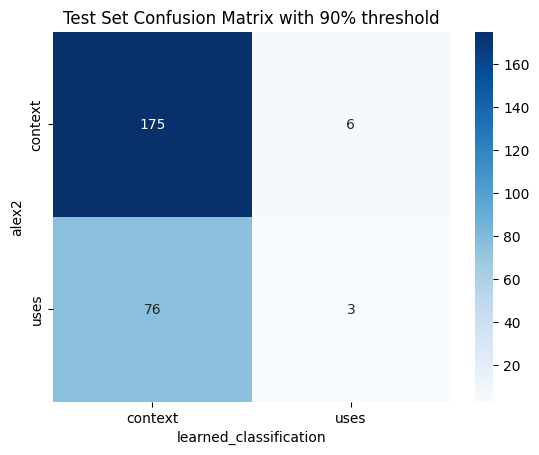

In [28]:
split = floor(.5 * len(df))
true = df[y_label][split:]
pred = df[x_label][split:]

print(f"Test labels hash: {hash_dataframe(list(true))}")


true, pred = list(map(mapping, true)), list(map(mapping, pred))



cm = confusion_matrix(true, pred)
print(set(true), set(pred))
labels = sorted(list({mapping(item) for item in ['background', 'extends', 'uses']}))

diagonal = cm * np.identity(len(labels))
false_positives = (cm - diagonal).sum(axis = 0)/cm.sum(axis = 0)
false_negatives = (cm - diagonal).sum(axis = 1)/cm.sum(axis = 1)
accuracy = diagonal.sum() / cm.sum()

print(f"Accuracy {accuracy}")
print(f"Uses false positive: {false_positives[-1]}\n")
print(f"Uses false negative: {false_negatives[-1]}")
print(f"Extends false positive: {false_positives[1]}")
print(f"Extends false negative: {false_negatives[1]}")


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Test Set Confusion Matrix with 90% threshold")
plt.xlabel(x_label)
plt.ylabel(y_label)


In [29]:
raise Exception

Exception: 

# Inspect Confusion Matrix
## Get samples, option to relabel

In [ ]:
def get_examples(y_value, x_value):
    mask = (df[y_label].apply(mapping) == y_value) & (df[x_label].apply(mapping) == x_value) 
    return df[mask]

idx = -1
samples = get_examples(y_value='extends', x_value = 'uses')
samples.head()

,Unnamed: 0.1,sentence,mcllm,modelKey,paperId,modelId_x,mc,modelId_y,mc_reduced,urop_sentence,...,modelTitle,modelId,modelYear,paperYear,pot_extends,prob_extends,json_booleans,json_response,answer_vector,learned_classification
206,206,NaN,NaN,597_vgg19,63038fc985332903328fc0a5fffb9ec885701954,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"```json\n{\n ""quote_1"": ""the trained cnns a...","```json\n{\n ""quote_1"": ""the trained cnns a...",[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0],uses
503,503,NaN,NaN,1064_bert-large,1dd5beb70fe2a4ace695d3fc7f1fb0c53f757d87,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"```json\n{\n ""quote_1"": ""table 2: baseline ...","```json\n{\n ""quote_1"": ""table 2: baseline ...",[1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0],uses


In [ ]:
idx += 1
index = samples.index[idx]
print(idx, index)
print(f"Drawing from {len(samples)} samples")
print(samples['modelKey'].iloc[idx])

print(samples['multisentence'].iloc[idx])
print(samples[label_col].iloc[idx])
get_truth(samples[label_col].iloc[idx], verbose = True)


print(samples[y_label].iloc[idx])
print(samples[x_label].iloc[idx])

0 206
Drawing from 2 samples
597_vgg19
##  4 experimental setup

this section describes in detail the experimental setup for collecting data and the set of conducted deep net profiling experiments. to enforce the generality of the proposed approach, different open source frameworks and multiple nns have been considered. the adopted frameworks are _pytorch 0.3.1_paszke et al (2017); pytorch (2018) and _tensorflow 1.8.0_abadi et al (2016); tensorflow (2018), while the trained cnns are alexnet krizhevsky et al (2012), resnet-50 he et al (2015), and vgg-19 <cite>simonyan and zisserman (2014)</cite>, whose implementations are already available within the considered frameworks.
```json
{
    "quote_1": "the trained cnns are alexnet krizhevsky et al (2012), resnet-50 he et al (2015), and vgg-19 <cite>simonyan and zisserman (2014)</cite>, whose implementations are already available within the considered frameworks.",
    "explanation_1": "The sentence does not mention results from the cited pa

In [ ]:
df_temp = pd.read_csv(master_path + '.csv')
assert(df_temp['multisentence'].loc[index] == df['multisentence'].loc[index])
print(df_temp['multisentence'].loc[index])
reclass = input()

if (len(reclass) > 0):
    df_temp['alex2'].loc[index] = reclass
    df_temp.to_csv(master_path + '.csv', index = False)

##  4 experimental setup

this section describes in detail the experimental setup for collecting data and the set of conducted deep net profiling experiments. to enforce the generality of the proposed approach, different open source frameworks and multiple nns have been considered. the adopted frameworks are _pytorch 0.3.1_paszke et al (2017); pytorch (2018) and _tensorflow 1.8.0_abadi et al (2016); tensorflow (2018), while the trained cnns are alexnet krizhevsky et al (2012), resnet-50 he et al (2015), and vgg-19 <cite>simonyan and zisserman (2014)</cite>, whose implementations are already available within the considered frameworks.


# Reprompt on samples

In [ ]:
retry_sample = True
if (retry_sample):
    for idx in tqdm(samples.index):    
        df[label_col].at[idx] = prompt(
                                    MULTIPROMPT.format(
                                            input = df['multisentence'].loc[idx], 
                                            modelKey = df['modelKeyStriped'].loc[idx]))
CONNECTION_ON = False

  0%|          | 0/2 [00:00<?, ?it/s]


NameError: name 'MULTIPROMPT' is not defined

In [ ]:
Counter([df['gpt-vector'].loc[i] for i in samples.index])

Counter({'uses': 25, 'background': 16, None: 2})